# MACHINE TRANSLATION Using Seq2Seq Modelling

The objective is to Explain How Seq 2 Seq and LSTMs are used for Machine Translations using an example dataset of converting a German sentence to its English counterpart. This code is greatly inspired from this [link](https://www.kaggle.com/code/harshjain123/machine-translation-seq2seq-lstms/notebook).

## What is Seq2Seq Modelling ?

Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to German). Our aim is to translate given sentences from German language to English.


Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, DNA sequence modeling, among others.

Here, both the input and output are sentences. In other words, these sentences are a sequence of words going in and out of a model. This is the basic idea of Sequence-to-Sequence modeling. The figure below tries to explain this method.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/01/enc_dec_simple.png)


### Here's how it works:

- Feed the embedding vectors for source sequences (German), to the encoder network, one word at a time.</li>

- Encode the input sentences into fixed dimension state vectors. At this step, we get the hidden and cell states from the encoder LSTM, and feed it to the decoder LSTM.
    
- These states are regarded as initial states by decoder. Additionally, it also has the embedding vectors for target words (English).
    
- Decode and output the translated sentence, one word at a time. In this step, the output of the decoder is sent to a softmax layer over the entire target vocabulary.

## Import the Required Libraries

In [1]:
# For string manipulation and data i/o
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

# For visualization and plotting
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

## Load the Data 

In this example we shall convert german(deutsche) to english. So loading the necessary files. 

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
        
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("./deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000,:]

**Note:**The actual data contains over 150,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model.

## Text Cleaning / Preprocessing

We will get rid of the punctuation marks and then convert all the text to lower case.

In [6]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [7]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

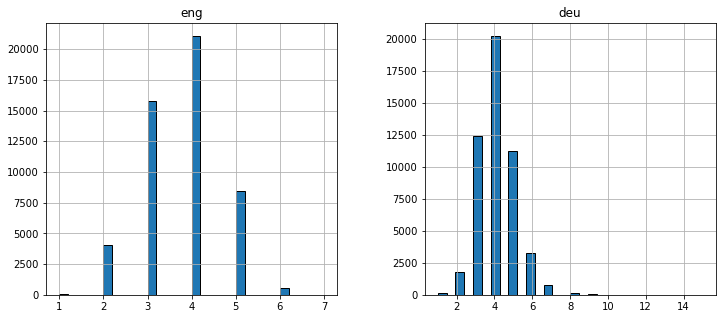

In [8]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30, edgecolor='k', figsize = (12,5))
plt.show()

- A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.
    
- Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.
    
- Prepare tokenizers for both the German and English sentences.

In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [11]:
eng_tokenizer.index_word

{1: 'tom',
 2: 'i',
 3: 'you',
 4: 'is',
 5: 'a',
 6: 'it',
 7: 'the',
 8: 'to',
 9: 'me',
 10: 'im',
 11: 'he',
 12: 'do',
 13: 'that',
 14: 'was',
 15: 'this',
 16: 'my',
 17: 'are',
 18: 'we',
 19: 'dont',
 20: 'have',
 21: 'your',
 22: 'did',
 23: 'like',
 24: 'its',
 25: 'can',
 26: 'youre',
 27: 'not',
 28: 'be',
 29: 'go',
 30: 'in',
 31: 'what',
 32: 'were',
 33: 'here',
 34: 'she',
 35: 'know',
 36: 'they',
 37: 'ill',
 38: 'want',
 39: 'very',
 40: 'now',
 41: 'how',
 42: 'on',
 43: 'cant',
 44: 'has',
 45: 'up',
 46: 'for',
 47: 'get',
 48: 'thats',
 49: 'need',
 50: 'no',
 51: 'at',
 52: 'toms',
 53: 'come',
 54: 'isnt',
 55: 'of',
 56: 'why',
 57: 'him',
 58: 'good',
 59: 'who',
 60: 'help',
 61: 'one',
 62: 'out',
 63: 'will',
 64: 'his',
 65: 'us',
 66: 'too',
 67: 'all',
 68: 'please',
 69: 'just',
 70: 'love',
 71: 'there',
 72: 'got',
 73: 'home',
 74: 'well',
 75: 'with',
 76: 'didnt',
 77: 'see',
 78: 'mary',
 79: 'am',
 80: 'stop',
 81: 'hes',
 82: 'look',
 83: 'ca

In [12]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


- We tokenized the data — i.e., converted the words to word index.
- When we run the tokenizer, it creates a word index, which is then used to convert each sentence to a vector.

In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

- When we feed our sequences of word IDs into the model, each sequence needs to be the same length. To achieve this, padding is added to any sequence that is shorter than the max length (i.e. shorter than the longest sentence).

![](https://miro.medium.com/max/1728/0*6jZTOE0P7_i7N8pn.png)

## Model Building

**First, let’s breakdown the architecture of an RNN at a high level. Referring to the diagram above, there are a few parts of the model we to be aware of:**

- **Inputs.** Input sequences are fed into the model with one word for every time step. Each word is encoded as a unique integer so that it maps to the German dataset vocabulary.</li>

- **Embedding Layers.** Embeddings are used to convert each word to a vector. The size of the vector depends on the complexity of the vocabulary.


- **LSTM Layer (Encoder).** This is where the context from word vectors in previous time steps is applied to the current word vector.


- **Dense Layers (Decoder).** These are typical fully connected layers used to decode the encoded input into the correct translation sequence.

- The outputs are returned as a sequence of integers or one-hot encoded vectors which can then be mapped to the English dataset vocabulary.
    
    
### Model Architecture

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/01/architecture.png)

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It’s time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. This has to be done for both the train and test datasets.

- Input is deutsche
- Output is english

In [15]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])   
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])   

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
trainX[:5]

array([[   1,   44,    7,   46,   40,   79,    0,    0],
       [  17, 1994,   69,  319,    0,    0,    0,    0],
       [  59, 2577,    2,    0,    0,    0,    0,    0],
       [ 581,   46,   16,   15,  726,    0,    0,    0],
       [  11,   25,   26, 1379,    0,    0,    0,    0]], dtype=int32)

## Define the Model

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    # sequential model for seq2seq network
    model = Sequential()
    # add embedding layer
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    # LSTM network
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [18]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [19]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

- We are using the RMSprop optimizer.
        
- Here I have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.

## Fit the Model

*ModelCheckpoint()* function to save the model with the lowest validation loss. 

We are training for 30 epochs only. But in practice we should run for higher number of epochs. More epochs $\rightarrow$ more training time

In [20]:
filename = 'seq_2_seq_model'

In [21]:
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=128, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 3.2558
Epoch 1: val_loss improved from inf to 2.81682, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 181s 699ms/step - loss: 3.2558 - val_loss: 2.8168
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 2.7595
Epoch 2: val_loss improved from 2.81682 to 2.74142, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 174s 695ms/step - loss: 2.7595 - val_loss: 2.7414
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 2.6953
Epoch 3: val_loss improved from 2.74142 to 2.66906, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 170s 682ms/step - loss: 2.6953 - val_loss: 2.6691
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 2.6144
Epoch 4: val_loss improved from 2.66906 to 2.60052, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 171s 683ms/step - loss: 2.6144 - val_loss: 2.6005
Epoch 5/30
250/250 [==============================] - ETA: 0s - loss: 2.5429
Epoch 5: val_loss improved from 2.60052 to 2.52888, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 171s 683ms/step - loss: 2.5429 - val_loss: 2.5289
Epoch 6/30
250/250 [==============================] - ETA: 0s - loss: 2.4635
Epoch 6: val_loss improved from 2.52888 to 2.45120, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 174s 695ms/step - loss: 2.4635 - val_loss: 2.4512
Epoch 7/30
250/250 [==============================] - ETA: 0s - loss: 2.3883
Epoch 7: val_loss improved from 2.45120 to 2.38503, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 172s 690ms/step - loss: 2.3883 - val_loss: 2.3850
Epoch 8/30
250/250 [==============================] - ETA: 0s - loss: 2.3198
Epoch 8: val_loss improved from 2.38503 to 2.33724, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 171s 685ms/step - loss: 2.3198 - val_loss: 2.3372
Epoch 9/30
250/250 [==============================] - ETA: 0s - loss: 2.2504
Epoch 9: val_loss improved from 2.33724 to 2.26903, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 171s 685ms/step - loss: 2.2504 - val_loss: 2.2690
Epoch 10/30
250/250 [==============================] - ETA: 0s - loss: 2.1800
Epoch 10: val_loss improved from 2.26903 to 2.20972, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 172s 687ms/step - loss: 2.1800 - val_loss: 2.2097
Epoch 11/30
250/250 [==============================] - ETA: 0s - loss: 2.1114
Epoch 11: val_loss improved from 2.20972 to 2.15509, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 172s 689ms/step - loss: 2.1114 - val_loss: 2.1551
Epoch 12/30
250/250 [==============================] - ETA: 0s - loss: 2.0502
Epoch 12: val_loss improved from 2.15509 to 2.10058, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 692ms/step - loss: 2.0502 - val_loss: 2.1006
Epoch 13/30
250/250 [==============================] - ETA: 0s - loss: 1.9880
Epoch 13: val_loss improved from 2.10058 to 2.04826, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 171s 686ms/step - loss: 1.9880 - val_loss: 2.0483
Epoch 14/30
250/250 [==============================] - ETA: 0s - loss: 1.9268
Epoch 14: val_loss improved from 2.04826 to 1.99435, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 691ms/step - loss: 1.9268 - val_loss: 1.9944
Epoch 15/30
250/250 [==============================] - ETA: 0s - loss: 1.8630
Epoch 15: val_loss improved from 1.99435 to 1.94469, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 693ms/step - loss: 1.8630 - val_loss: 1.9447
Epoch 16/30
250/250 [==============================] - ETA: 0s - loss: 1.8019
Epoch 16: val_loss improved from 1.94469 to 1.90764, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 690ms/step - loss: 1.8019 - val_loss: 1.9076
Epoch 17/30
250/250 [==============================] - ETA: 0s - loss: 1.7394
Epoch 17: val_loss improved from 1.90764 to 1.85782, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 692ms/step - loss: 1.7394 - val_loss: 1.8578
Epoch 18/30
250/250 [==============================] - ETA: 0s - loss: 1.6793
Epoch 18: val_loss improved from 1.85782 to 1.79968, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 172s 689ms/step - loss: 1.6793 - val_loss: 1.7997
Epoch 19/30
250/250 [==============================] - ETA: 0s - loss: 1.6230
Epoch 19: val_loss improved from 1.79968 to 1.77021, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 693ms/step - loss: 1.6230 - val_loss: 1.7702
Epoch 20/30
250/250 [==============================] - ETA: 0s - loss: 1.5691
Epoch 20: val_loss improved from 1.77021 to 1.72420, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 694ms/step - loss: 1.5691 - val_loss: 1.7242
Epoch 21/30
250/250 [==============================] - ETA: 0s - loss: 1.5182
Epoch 21: val_loss improved from 1.72420 to 1.68791, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 174s 697ms/step - loss: 1.5182 - val_loss: 1.6879
Epoch 22/30
250/250 [==============================] - ETA: 0s - loss: 1.4680
Epoch 22: val_loss improved from 1.68791 to 1.66287, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 692ms/step - loss: 1.4680 - val_loss: 1.6629
Epoch 23/30
250/250 [==============================] - ETA: 0s - loss: 1.4207
Epoch 23: val_loss improved from 1.66287 to 1.62860, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 174s 695ms/step - loss: 1.4207 - val_loss: 1.6286
Epoch 24/30
250/250 [==============================] - ETA: 0s - loss: 1.3760
Epoch 24: val_loss improved from 1.62860 to 1.59944, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 174s 697ms/step - loss: 1.3760 - val_loss: 1.5994
Epoch 25/30
250/250 [==============================] - ETA: 0s - loss: 1.3309
Epoch 25: val_loss improved from 1.59944 to 1.58616, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 694ms/step - loss: 1.3309 - val_loss: 1.5862
Epoch 26/30
250/250 [==============================] - ETA: 0s - loss: 1.2876
Epoch 26: val_loss improved from 1.58616 to 1.55482, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 692ms/step - loss: 1.2876 - val_loss: 1.5548
Epoch 27/30
250/250 [==============================] - ETA: 0s - loss: 1.2469
Epoch 27: val_loss improved from 1.55482 to 1.52435, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 175s 699ms/step - loss: 1.2469 - val_loss: 1.5243
Epoch 28/30
250/250 [==============================] - ETA: 0s - loss: 1.2050
Epoch 28: val_loss improved from 1.52435 to 1.51782, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 175s 700ms/step - loss: 1.2050 - val_loss: 1.5178
Epoch 29/30
250/250 [==============================] - ETA: 0s - loss: 1.1647
Epoch 29: val_loss improved from 1.51782 to 1.50140, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 692ms/step - loss: 1.1647 - val_loss: 1.5014
Epoch 30/30
250/250 [==============================] - ETA: 0s - loss: 1.1269
Epoch 30: val_loss improved from 1.50140 to 1.46639, saving model to seq_2_seq_model


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


INFO:tensorflow:Assets written to: seq_2_seq_model/assets


250/250 [==============================] - 173s 694ms/step - loss: 1.1269 - val_loss: 1.4664


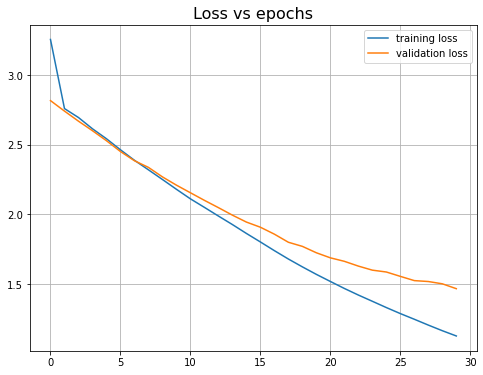

In [22]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.grid()
plt.title("Loss vs epochs",fontsize=16)
plt.show()

## Prediction on unseen data

As we have saved the model, we need not to train it again and we can load the saved model.

In [23]:
model = load_model(filename)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            5288448   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 6256)           3209328   
                                                                 
Total params: 12,696,176
Trainable params: 12,696,176
Non-trainable params: 0
____________________________________________

**Generating predictions**

In [25]:
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1]))[:1024,:],batch_size=128)

8/8 [==============================] - 4s 194ms/step


In [26]:
preds = preds.argmax(axis=2)

In [27]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [28]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [29]:
pred_df = pd.DataFrame({'actual' : test[:1024,0], 'predicted' : preds_text})

In [31]:
pred_df.head(20)

,actual,predicted
0,i know that already,i know that
1,whos she,who is
2,do you have it,did you
3,use your feet,put your
4,that was the trouble,tom came
5,he took off his coat,he took his
6,tom went sightseeing,tom took the
7,i tried on the shoes,i took the
8,open those doors,open the door
9,ive got to help tom,i have to help tom


## CONCLUSION

- Our Seq2Seq model does a decent job. But there are several instances where it misses out on understanding the key words.
- We can obtain better results by using more training data and building a better (or more complex) model.